# A Level-2 Sea Ice Drift (SID) algorithm for CIMR

This notebook implements a prototype for a Level-2 SIED algorithm for the CIMR mission.

We refer to the corresponding [ATBD](https://cimr-algos.github.io/SeaIceDrift_ATBD/intro.html) and especially the [Baseline Algorithm Definition](https://cimr-algos.github.io/SeaIceDrift_ATBD/baseline_algorithm_definition.html#baseline-algorithm-definition).

In particular, the figure below illustrates the overall concept of the processing:
<img src="https://cimr-algos.github.io/SeaIceDrift_ATBD/_images/CIMR_L2_Sea_Ice_Drift_Flow_Diagram.png" width="100%"/>

## Settings

Imports and general settings

In [1]:
%load_ext cython

In [2]:
# Root of directory and paths

import os
cpath = '/home/emilyjd/cimr-devalgo'
algpath = os.path.join(cpath, 'SeaIceDrift_ATBD_v2/algorithm/src_sied')
toolpath = os.path.join(cpath, 'Tools')

l1bpath = os.path.join(cpath, 'data/L1B')
concpath = os.path.join(cpath, 'data/conc')
icemaskpath = os.path.join(cpath, 'data/icemask')
swathpath = os.path.join(cpath, 'data/swaths')
procpath = os.path.join(cpath, 'data/processing')
driftpath = os.path.join(cpath, 'data/icedrift')
logpath = os.path.join(cpath, 'data/logs')

In [3]:
# Imports

from importlib import reload

import sys
import shutil
import numpy as np
import numpy.ma as ma
import xarray as xr
from netCDF4 import Dataset
from matplotlib import pylab as plt
import matplotlib.cm as cm
#import cmocean
from pyresample import parse_area_file
from datetime import datetime, timedelta

# Local modules contain software code that implement the SIED algorithm
if algpath not in sys.path:
    sys.path.insert(0, algpath)
#from src_sied import *
from icedrift_wrapper import icedrift_wrapper
from process_ice_mask import process_ice_mask

# prototype re-gridding toolbox to handle the L1B input
if toolpath not in sys.path:
    sys.path.insert(0, toolpath)
from tools import io_handler as io
from tools import collocation as coll
from tools import l2_format as l2

In [4]:
# Plot settings

import matplotlib
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'axes.labelsize': 12})

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
cmap = cm.viridis

## Parametrize the run

User-set parameters for the running of the whole notebook

In [5]:
hemi = 'nh'
algos = {'KU': {'channels':('tb19v', 'tb19h'), 'target_band':'KU'},
         'KA': {'channels':('tb37v', 'tb37h'), 'target_band':'KA'}}
wbs = list(algos.keys())
fwdbck = ['fw', 'bk']
polarisation = {'V': 0, 'H': 1}
pols = list(polarisation.keys())

test_card = "radiometric"
if test_card == "geometric":
    # DEVALGO's simulated geometric test card
    l1bfn = 'W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20230417T105425_LD_20280110T114800_20280110T115700_TN.nc'
elif test_card == "radiometric":
    # DEVALGO's simulated radiometric test card
    l1bfn = 'W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20230420T103323_LD_20280110T114800_20280110T115700_TN.nc'

#dt = datetime.strptime('20230417T105425', '%Y%m%dT%H%M%S')
dt = datetime.strptime('20230420T103323', '%Y%m%dT%H%M%S')

l1bfile = os.path.join(l1bpath, l1bfn)

pdate = datetime.strptime('20280110', '%Y%m%d')
qdate = pdate + timedelta(days=1)

# Icemask data and output locations
icemaskinput = os.path.join(concpath, 'ice_conc_{}_ease-125_reproc_{:%Y%m%d}1200.nc'.format(hemi, pdate))
icemaskgridfile = os.path.join(algpath, 'grids_py.def')

algo_version = '0.1'

TODO: Better define times. an approximation is to use the same time for all forward/backward scans, all channels and all polarities for each hemisphere. Just one time applied to the NH and one to the SH.

## Step 1: Pre-processing (Icemask, loading the files, Laplacian pre-processing)


### Step 1a: Creating and regridding the ice mask


A land/ocean/ice mask is required to define the areas with ice to the algorithm. This is created from a concentration file, and is stored for future use. Since there can be multiple ice drift calculations per day on different swaths, the mask can be reused once created.

[]

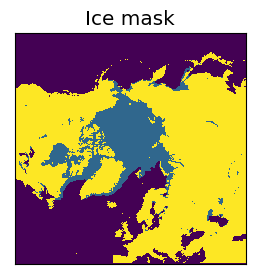

In [6]:
# Creating the ice mask
gridname = '{}-ease2-050'.format(hemi)
icemaskname = os.path.join(icemaskpath, 'icemask-multi-{}-{:%Y%m%d}12.nc'.format(gridname, pdate))
if not os.path.isfile(icemaskname):
    process_ice_mask(icemaskinput, icemaskpath, icemaskgridfile, gridname)

# Reading in the ice mask
ie_data = Dataset(icemaskname, 'r')
ie = ie_data['ice_edge'][0, :, :]

# And the same for the output grid
gridnameout = '{}-ease2-750'.format(hemi)
icemasknameout = os.path.join(icemaskpath, 'icemask-multi-{}-{:%Y%m%d}12.nc'.format(gridnameout, pdate))
if not os.path.isfile(icemasknameout):
    process_ice_mask(icemaskinput, icemaskpath, icemaskgridfile, gridnameout)
ie_data_out = Dataset(icemasknameout, 'r')
ieout = ie_data_out['ice_edge'][0, :, :]

# Plotting the ice mask
fig = plt.figure(figsize=(3,3))
ax1 = fig.add_subplot(1,1,1)
c1 = ax1.imshow(ie[:], interpolation = 'none', cmap=cmap)
ax1.set_title("Ice mask")
ax1.xaxis.set_tick_params(labelbottom=False)
ax1.yaxis.set_tick_params(labelleft=False)
ax1.set_xticks([])
ax1.set_yticks([])

### Step 1b: Loading the data


The L1B data is read in and split into forward and backward scans using software from the `Tools/` repository (a prototype CIMR Regridding Toolbox developed in the CIMR DEVALGO study).

In [7]:
# Read the bands needed of the L1B data
reload(io)

tb_dict = {'tb01':'L', 'tb06':'C', 'tb10':'X', 'tb19':'KU', 'tb37':'KA'}
rev_tb_dict = {v:k for k,v in tb_dict.items()}
bands_needed = []
for alg in algos.keys():
    bands_needed += algos[alg]['channels']
bands_needed = list(set([tb_dict[b[:-1]] for b in bands_needed]))

full_l1b = io.CIMR_L1B(l1bfile, selected_bands=bands_needed, keep_calibration_view=True)

In [8]:
# Split into forward / backward scan

l1b = {}
l1b['fw'], l1b['bk'] = full_l1b.split_forward_backward_scans(method='horn_scan_angle')

### Step 1c: Regridding the data

The horns are interleaved, and then the data is regridded. These are again done with software from `Tools/`. The ice drift will be calculated individually on 8 fields based on the forward and backward scans, waveband (Ku or Ka), and polarity (V or H). A fine EASE2 grid spacing of 5km is chosen for this regridding. 

In [9]:
# Regridding the data

reload(coll)

# Reshaping
l1b_r = {}
for fb in fwdbck:
    l1b_r[fb] = l1b[fb].reshape_interleave_feed()

# Loading the target grid information
gridname = '{}-ease2-050'.format(hemi)
new_area_def = parse_area_file(icemaskgridfile, gridname)[0]
new_lons, new_lats = new_area_def.get_lonlats()

# Getting the input lat/lons
lonlats = {}
for ll in ['lon', 'lat']:
    lonlats[ll] = {}
    for fb in fwdbck:
        lonlats[ll][fb] = {}
        for wb in wbs:
            lonlats[ll][fb][wb] = l1b_r[fb].data[wb][ll].data

# Creating data arrays with the V and H layers
what = ('brightness_temperature_v', 'brightness_temperature_h')
params = {'method':'gauss', 'sigmas':25000, 'neighbours':55}
stack_shape = {}
stack = {}
regrid = {}
for fb in fwdbck:
    stack_shape[fb] = {}
    stack[fb] = {}
    regrid[fb] = {}
    for wb in wbs:
        stack_shape[fb][wb] = tuple(list(lonlats['lat'][fb][wb].shape) + [len(what),])
        stack[fb][wb] = np.empty(stack_shape[fb][wb])
        for iw, w in enumerate(what):
            stack[fb][wb][...,iw] = l1b_r[fb].data[wb][w].data
            # Regridding
            regrid[fb][wb] = coll._regrid_fields(new_lons, new_lats, 
                                                 lonlats['lon'][fb][wb], lonlats['lat'][fb][wb], stack[fb][wb])


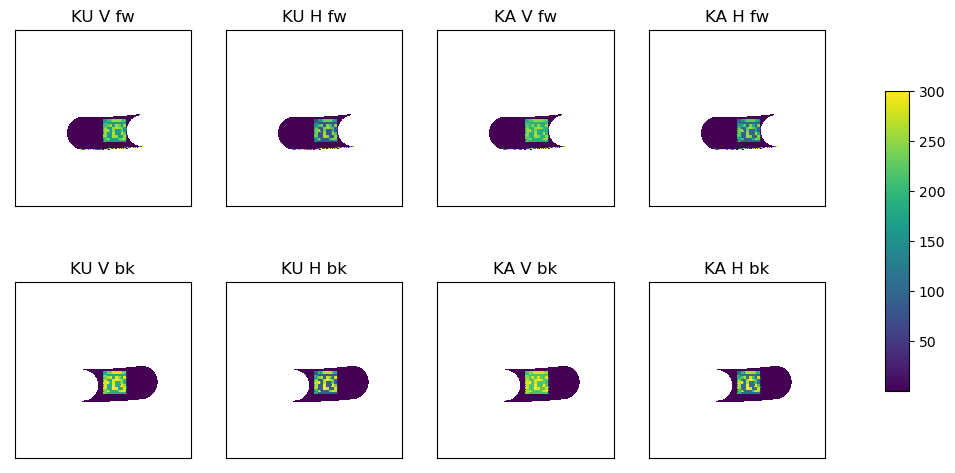

In [10]:
# Plot regridded

fig = plt.figure(figsize=(12,6))
ax = {}
c = {}
shapelayout = (len(fwdbck), len(wbs) * len(pols))
axindex = 1
for fb in fwdbck:
    for wb in wbs:
        for pol in pols:
            ax[axindex] = fig.add_subplot(*shapelayout, axindex)
            c[axindex] = ax[axindex].imshow(regrid[fb][wb][:, :, polarisation[pol]], interpolation = 'none', 
                                            origin='lower', cmap=cmap)
            ax[axindex].invert_yaxis()
            ax[axindex].set_title("{} {} {}".format(wb, pol, fb), fontsize=12)
            ax[axindex].xaxis.set_tick_params(labelbottom=False)
            ax[axindex].yaxis.set_tick_params(labelleft=False)
            ax[axindex].set_xticks([])
            ax[axindex].set_yticks([])
            axindex += 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(c[1], cax=cbar_ax, shrink=0.5)


# Step 1d: Laplacian pre-processing


Instead of directly using the brightness temperatures in the motion tracking algorithm, the ice features are stabilised and enhanced by applying a Laplacian filter (see ATBD for mathmatical description).

In [11]:
# Laplacian pre-processing

from scipy.ndimage import laplace


# Replace fill value by NaN and remove mask
def _get_nans(img):
    img_masked = np.ma.asarray(img)
    return img_masked.filled(np.nan)

# Replace NaN by fill value and add mask
def _mask_nans(img):
    return np.ma.masked_invalid(img)

nan = {}
lap = {}
fv = {}
for fb in fwdbck:
    nan[fb] = {}
    lap[fb] = {}
    fv[fb] = {}
    for wb in wbs:
        # Convert fill values to NaNs
        nan[fb][wb] = _get_nans(regrid[fb][wb])
        # Laplacian transform
        lap[fb][wb] = laplace(nan[fb][wb])
        # Converting NaNs to fill values
        fv[fb][wb] = _mask_nans(lap[fb][wb])

# Creating a flag field
#define TCIMAGE_OUTSIDE_GRID              -2
#define TCIMAGE_NODATA                    -1
#define TCIMAGE_OK                         0
#define TCIMAGE_UNPROCESSED                1
#define TCIMAGE_FAILED                     2
flag = {}
for fb in fwdbck:
    flag[fb] = {}
    for wb in wbs:
        flag[fb][wb] = np.zeros_like(fv[fb][wb])
        # Masking where the Laplacian didn't work
        flag[fb][wb][fv[fb][wb].mask] = -1
        # Masking where the land and ocean is
        landocean = np.logical_or(ie == 9, ie == 1)
        flag[fb][wb][landocean] = 1
        #TODO - The ocean not masked in landocean (but masked by NODATA, so don't worry now)


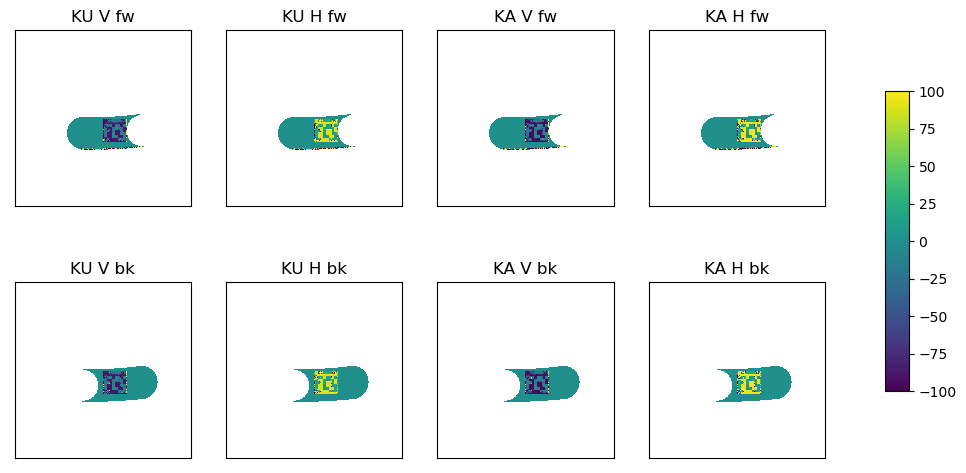

In [12]:
# Plot Laplacian

vmin = -100
vmax = 100

fig = plt.figure(figsize=(12,6))
ax = {}
c = {}
shapelayout = (len(fwdbck), len(wbs) * len(pols))
axindex = 1
for fb in fwdbck:
    for wb in wbs:
        for pol in pols:
            ax[axindex] = fig.add_subplot(*shapelayout, axindex)
            c[axindex] = ax[axindex].imshow(fv[fb][wb][:, :, polarisation[pol]], interpolation = 'none', 
                                            origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
            ax[axindex].invert_yaxis()
            ax[axindex].set_title("{} {} {}".format(wb, pol, fb), fontsize=12)
            ax[axindex].xaxis.set_tick_params(labelbottom=False)
            ax[axindex].yaxis.set_tick_params(labelleft=False)
            ax[axindex].set_xticks([])
            ax[axindex].set_yticks([])
            axindex += 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(c[1], cax=cbar_ax, shrink=0.5)

NameError: name 'fwd_ku_fv' is not defined

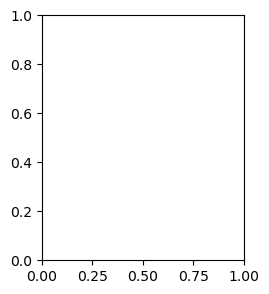

In [13]:
# Plot Laplacian zoomed

fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(2,4,1)
c1 = ax1.imshow(fwd_ku_fv[1000:1500, 1000:1500, 0], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax1.set_title("Ku V fwd")
ax2 = fig.add_subplot(2,4,2)
c2 = ax2.imshow(fwd_ku_fv[1000:1500, 1000:1500, 1], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax2.set_title("Ku H fwd")
ax3 = fig.add_subplot(2,4,3)
c3 = ax3.imshow(fwd_ka_fv[1000:1500, 1000:1500, 0], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax3.set_title("Ka V fwd")
ax4 = fig.add_subplot(2,4,4)
c4 = ax4.imshow(fwd_ka_fv[1000:1500, 1000:1500, 1], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax4.set_title("Ka H fwd")

ax5 = fig.add_subplot(2,4,5)
c5 = ax5.imshow(bck_ku_fv[1000:1500, 1000:1500, 0], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax5.set_title("Ku V bck")
ax6 = fig.add_subplot(2,4,6)
c6 = ax6.imshow(bck_ku_fv[1000:1500, 1000:1500, 1], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax6.set_title("Ku H bck")
ax7 = fig.add_subplot(2,4,7)
c7 = ax7.imshow(bck_ka_fv[1000:1500, 1000:1500, 0], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax7.set_title("Ka V bck")
ax8 = fig.add_subplot(2,4,8)
c8 = ax8.imshow(bck_ka_fv[1000:1500, 1000:1500, 1], interpolation = 'none', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
ax8.set_title("Ka H bck")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(c1, cax=cbar_ax, shrink=0.5)

# Step 1e: Writing out the file


For ice drift, it is not possible to keep the data only internally. Since two gridded files at different timepoints are required to create each gridded map of icedrift vectors, it is necessary to write each gridded swath file to disk so that it can be read in to be compared with other gridded swath files.

In [15]:
crs_info = {'proj4_string': new_area_def.proj4_string,
             'area_id': new_area_def.area_id,
             'semi_major_axis': 6378137.,
             'semi_minor_axis': 6356752.31424518,
             'inverse_flattening': 298.257223563,
             'reference_ellipsoid_name': "WGS 84",
             'longitude_of_prime_meridian': 0.,
             'prime_meridian_name': "Greenwich",
             'geographic_crs_name': "unknown",
             'horizontal_datum_name': "World Geodetic System 1984",
             'projected_crs_name': "unknown",
             'grid_mapping_name': "lambert_azimuthal_equal_area",
             'latitude_of_projection_origin': 90.,
             'longitude_of_projection_origin': 0.,
             'false_easting': 0.,
             'false_northing': 0.}

/modules/rhel8/conda/install/envs/production-08-2023/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [53]:
reload(l2)

## Associate a time to this L2 product
#min_l1b_dt = full_l1b.data[wbs[0]]['time_earth'].data.min()
#max_l1b_dt = full_l1b.data[wbs[0]]['time_earth'].data.max()
## Some simulated files have a wrong units of 'days', then we get 'time_earth' as timedelta64. Fix for these.
##if full_l1b.data[wbs[0]['time_earth'].encoding['units'] == 'days':
#    print("Correct L1B time (wrong unit in L1B file)")
#    min_l1b_dt += np.datetime64('2000-01-01')
#    max_l1b_dt += np.datetime64('2000-01-01')
#
## Arbitrarily, associate middle time of l1b to l2
#l2_dt = min_l1b_dt + (max_l1b_dt - min_l1b_dt) * 0.5

# Get a template L2 format (netCDF/CF) from the Tools module
ds_l2 = l2.get_CIMR_L2_template('grid', geo_def=new_area_def, add_time=[pdate.timestamp()])

# Create data arrays for the brightness temperatures, laplacian processed and status flags from the template
shp = (1, *regrid[fwdbck[0]][wbs[0]][:, :, polarisation[pol]].shape)
ds_tb = {}
ds_lap = {}
ds_flag = {}
for fb in fwdbck:
    ds_tb[fb] = {}
    ds_lap[fb] = {}
    ds_flag[fb] = {}
    for wb in wbs:
        ds_tb[fb][wb] = {}
        ds_lap[fb][wb] = {}
        ds_flag[fb][wb] = {}
        for pol in pols:
            chan = algos[wb]['channels'][polarisation[pol]]
            ds_tb[fb][wb][pol] = xr.DataArray(regrid[fb][wb][:, :, polarisation[pol]].reshape(shp),
                                              coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                                              attrs=ds_l2['template'].attrs, name='{}{}'.format(chan, fb))
            ds_tb[fb][wb][pol].attrs['standard_name'] = 'brightness_temperature'
            ds_tb[fb][wb][pol].attrs['long_name'] = 'Brightness temperature {}'.format(chan, fb)
            ds_tb[fb][wb][pol].attrs['coverage_content_type'] = 'physicalMeasurement'
            ds_tb[fb][wb][pol].attrs['units'] = 'K'
            ds_l2 = ds_l2.merge(ds_tb[fb][wb][pol])
            
            ds_lap[fb][wb][pol] = xr.DataArray(fv[fb][wb][:, :, polarisation[pol]].reshape(shp),
                                               coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                                               attrs=ds_l2['template'].attrs, name='{}{}_lap'.format(chan, fb))
            ds_lap[fb][wb][pol].attrs['long_name'] = 'Laplacian of brightness temperature {}'.format(chan, fb)
            ds_lap[fb][wb][pol].attrs['coverage_content_type'] = 'auxiliaryInformation'
            ds_lap[fb][wb][pol].attrs['units'] = 1
            ds_l2 = ds_l2.merge(ds_lap[fb][wb][pol])
            
            ds_flag[fb][wb][pol] = xr.DataArray(flag[fb][wb][:, :, polarisation[pol]].reshape(shp),
                                                coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                                                attrs=ds_l2['template'].attrs, 
                                                name='{}{}_lap_flag'.format(chan, fb))
            ds_flag[fb][wb][pol].attrs['standard_name'] = 'status_flag'
            ds_flag[fb][wb][pol].attrs['long_name'] = 'Status flag for Laplacian of brightness temperature {}'.format(chan, fb)
            ds_flag[fb][wb][pol].attrs['coverage_content_type'] = 'qualityInformation'
            ds_flag[fb][wb][pol].attrs['units'] = 1
            ds_l2 = ds_l2.merge(ds_flag[fb][wb][pol])

# Create a data array for dtime from the template
dtime = np.full_like(regrid[fwdbck[0]][wbs[0]][:, :, 0], pdate.timestamp()).reshape(shp)
ds_dtime = xr.DataArray(dtime, coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                        attrs=ds_l2['template'].attrs, name='dtime')
ds_dtime.attrs['long_name'] = 'Time'
ds_dtime.attrs['standard_name'] = 'time'
ds_dtime.attrs['coverage_content_type'] = 'auxiliaryInformation'
ds_dtime.attrs['units'] = 'seconds since 1970-01-01 00:00:00'
ds_l2 = ds_l2.merge(ds_dtime)

# Create a data array for ice edge from the template
ds_ie = xr.DataArray(ie.reshape(shp), coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                     attrs=ds_l2['template'].attrs, name='ice_edge')
ds_ie.attrs['long_name'] = 'Ice edge'
ds_ie.attrs['coverage_content_type'] = 'auxiliaryInformation'
ds_ie.attrs['units'] = 1
ds_l2 = ds_l2.merge(ds_ie)

# Create a data array for time, needed by the C code
timedata = np.full_like(regrid[fb][wb][0, 0, 0], pdate.timestamp())
ds_l2['vtime'] = (('time'), timedata.reshape(1,))
ds_l2['time'].attrs = {'units': "seconds since 1970-01-01 00:00:00"}
ds_l2.attrs['long_name'] = 'Time'
ds_l2.attrs['coverage_content_type'] = 'auxiliaryInformation'
ds_l2.attrs['units'] = "seconds since 1970-01-01 00:00:00"

# Customize the global attributes
ds_l2.attrs['title'] = 'CIMR intermediate brightness temperatures for ice drift calculation'
ds_l2.attrs['summary'] = 'Intermediate brightness temperatures and Laplacian-processed fields with their status flags, written as intermadiate-processing file for ice drift calculations'
ds_l2.attrs['l1b_file'] = l1bfn
ds_l2.attrs['algorithm_version'] = algo_version
ds_l2.attrs['creator_name'] = 'Emily Down'
ds_l2.attrs['creator_email'] = 'emilyjd@met.no'
ds_l2.attrs['institution'] = 'Norwegian Meteorological Institute'

# CRS information needed for C code
ds_l2['crs'].attrs = crs_info

# Need to rename x and y to xc and yc for X code
ds_l2= ds_l2.rename({'x': 'xc','y': 'yc'})
    
# Remove the 'template' variable (we don't need it anymore)
#ds_l2 = ds_l2.drop('template')

# Write to file
dsname = os.path.join(procpath, 'bt_{}_{:%Y%m%d}.nc'.format(gridname, pdate))
ds_l2.to_netcdf(dsname, 'w', format="NETCDF4_CLASSIC")
print("Written {}".format(dsname))

Written /home/emilyjd/cimr-devalgo/data/processing/bt_nh-ease2-050_20280110.nc


### Step 1f (temporary): Creating a test gridded file with "time difference" 24h and 1 px added in each x and y


This is a temporary part of this notebook, to create a "test" file with different gridded brightness temperatures and a different timepoint. This is required for calculation of ice drift vectors. In this example, a constant shift of 2 pixels in the x-direction and 4 pixels in the y-direction is chosen.

In [55]:
# Create a shifted file. These are the pixel shifts
pixshx = 2
pixshy = 4

# Take a copy of the data xarray
ds_shift = ds_l2.copy()

# Add the Laplacian mask variable
ds_msk = {}
ds_msk = {}
ds_msk = {}
for fb in fwdbck:
    ds_msk[fb] = {}
    for wb in wbs:
        ds_msk[fb][wb] = {}
        for pol in pols:
            chan = algos[wb]['channels'][polarisation[pol]]
            ds_msk[fb][wb][pol] = xr.DataArray(fv[fb][wb][:, :, polarisation[pol]].mask.reshape(shp),
                                               coords=ds_shift['template'].coords, dims=ds_shift['template'].dims,
                                               attrs=ds_shift['template'].attrs, name='{}{}_msk'.format(chan, fb))
            ds_msk[fb][wb][pol].attrs['long_name'] = 'Mask for Laplacian of brightness temperature {}'.format(chan, fb)
            ds_msk[fb][wb][pol].attrs['coverage_content_type'] = 'auxiliaryInformation'
            ds_msk[fb][wb][pol].attrs['units'] = 1
            ds_shift = ds_shift.merge(ds_msk[fb][wb][pol])

# Shifting the data pixels of the arrays
ds_shift_tb = {}
ds_shift_lap = {}
ds_shift_flag = {}
for fb in fwdbck:
    ds_shift_tb[fb] = {}
    ds_shift_lap[fb] = {}
    ds_shift_flag[fb] = {}
    for wb in wbs:
        ds_shift_tb[fb][wb] = {}
        ds_shift_lap[fb][wb] = {}
        ds_shift_flag[fb][wb] = {}
        for pol in pols:
            chan = algos[wb]['channels'][polarisation[pol]]
            # Shift can be used in xarray to shift dimension by number of pix. Note that the dimensions must be
            # called x and y within xarray
            chan = algos[wb]['channels'][polarisation[pol]]
            tbname = '{}{}'.format(chan, fb)
            ds_shift_tb[fb][wb] = ds_shift.get(tbname).shift(xc=pixshx, yc=pixshy)
            ds_shift[tbname].data = ds_shift_tb[fb][wb]
            # Shifting the Laplacian field
            lapname = '{}{}_lap'.format(chan, fb)
            ds_shift_lap[fb][wb] = ds_shift.get(lapname).shift(xc=pixshx, yc=pixshy)
            ds_shift[lapname].data = ds_shift_lap[fb][wb]
            # Flag field (want the data shifted, the landmask not)  
            flagname = '{}{}_lap_flag'.format(chan, fb)
            ds_shift_flag[fb][wb] = np.zeros_like(ds_shift_lap[fb][wb])
            # Masking where the Laplacian failed
            maskname = '{}{}_msk'.format(chan, fb)
            fmsk_shft = ds_shift.get(maskname).shift(xc=pixshx, yc=pixshy)
            ds_shift_flag[fb][wb][fmsk_shft == 1] = -1
            # Masking where the land and ocean is
            landocean = np.logical_or(ie == 9, ie == 1).reshape(shp)
            (ds_shift_flag[fb][wb])[landocean] = 1
            ds_shift[flagname].data = ds_shift_flag[fb][wb]

# Shift time by 24h
ds_shift['dtime'].data = np.full_like(regrid[fwdbck[0]][wbs[0]][:, :, 0], qdate.timestamp()).reshape(shp)
ds_shift.assign_coords(time = [qdate.timestamp()])

# Remove the mask variables (we don't need them anymore)
for fb in fwdbck:
    for wb in wbs:
        for pol in pols:
            chan = algos[wb]['channels'][polarisation[pol]]
            maskname = '{}{}_msk'.format(chan, fb)
            ds_shift = ds_shift.drop(maskname)

# Write to file
dsname2 = os.path.join(procpath, 'bt_{}_{:%Y%m%d}.nc'.format(gridname, qdate))
ds_shift.to_netcdf(dsname2, 'w', format="NETCDF4_CLASSIC")
print("Written {}".format(dsname2))

Written /home/emilyjd/cimr-devalgo/data/processing/bt_nh-ease2-050_20280111.nc


## Step 2: Cross-correlation algorithm


For the Continuous Maximum Cross-Correlation algorithm, two brightness temperature gridded files, enhanced by the Laplacian algorithm and with different timestamps, are required. The algorithm matches features between these images on a fractional pixel grid. As an example, only one channel is used so far, KU H-band forward scan. 

In [59]:
# Copying the files with new names, to interface with the C-code

chanstr = 'tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk'
newname1 = 'tc_wght_cimr-cimr_{}_{}-ease2-050_{}12.nc'.format(chanstr, hemi, datetime.strftime(pdate, '%Y%m%d'))
newname2 = 'tc_wght_cimr-cimr_{}_{}-ease2-050_{}12.nc'.format(chanstr, hemi, datetime.strftime(qdate, '%Y%m%d'))
shutil.copyfile(dsname, os.path.join(os.path.dirname(dsname), newname1))
shutil.copyfile(dsname2, os.path.join(os.path.dirname(dsname), newname2))

'/home/emilyjd/cimr-devalgo/data/processing/tc_wght_cimr-cimr_tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk_nh-ease2-050_2028011112.nc'

In [57]:
%load_ext autoreload
%autoreload
from icedrift_wrapper import icedrift_wrapper

chan_list = ['tb19hfw_lap']
idrift = icedrift_wrapper(pdate, qdate, procpath, procpath, driftpath, os.path.join(logpath, 'cmcc-test.log'),
                          'cimr-cimr', 'nh-ease2-050', chan_list, 75., 125.)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
WBS =  tb19hfw

Daily maps found (cimr-cimr):

	Day 1 : /home/emilyjd/cimr-devalgo/data/processing/tc_wght_cimr-cimr_tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk_nh-ease2-050_2028011012.nc 

	Day 2 : /home/emilyjd/cimr-devalgo/data/processing/tc_wght_cimr-cimr_tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk_nh-ease2-050_2028011112.nc 





/modules/rhel8/conda/install/envs/production-08-2023/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Calling the C core code...
50510}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,3.750510}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,3.750510}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,3.750510}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,3.750510}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,3.750510}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,3.750510}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,3.750510}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,3.750510}. Score=-nan
The maximum number of iterations (

The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,-12.806956}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.840541}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.840541}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.840541}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.840541}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.840541}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.840541}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.840541}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up t

The example shift between the files is 2 pixels in the x-direction and 4-pixels in the y-direction. On the 5km grid, this translates to 10km in x and 20km in y.

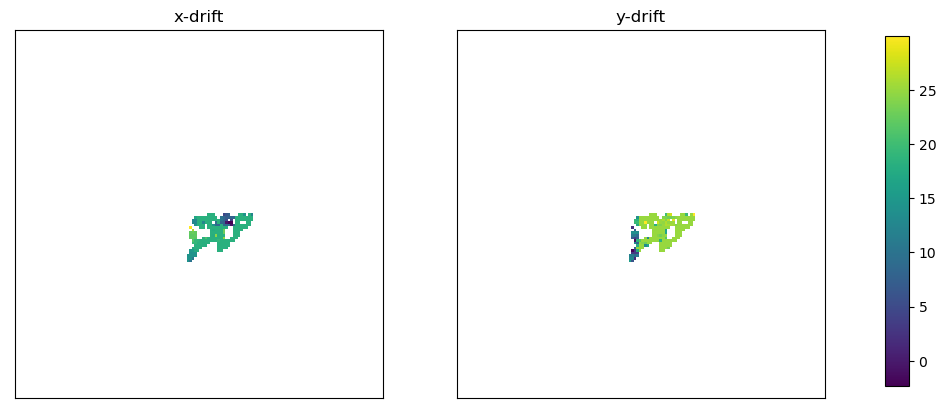

In [58]:
# Plot ice drift

driftx = ma.asarray(idrift['drift_x'])
driftx.mask = driftx < -1e9
drifty = ma.asarray(idrift['drift_y'])
drifty.mask = drifty < -1e9
xydata = {'dx': driftx, 'dy': drifty}

fig = plt.figure(figsize=(12,7))
ax = {}
c = {}
for i, var in enumerate(list(xydata.keys())):
    ax[i] = fig.add_subplot(1,len(xydata),i+1)
    c[i] = ax[i].imshow(xydata[var][:], interpolation = 'none', origin='lower', cmap=cmap)
    ax[i].invert_yaxis()
    ax[i].set_title('{}-drift'.format(var[1:2]), fontsize=12)
    ax[i].xaxis.set_tick_params(labelbottom=False)
    ax[i].yaxis.set_tick_params(labelleft=False)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(c1, cax=cbar_ax, shrink=0.5)

pixshx =  2
pixshx * pixsize =  10.0


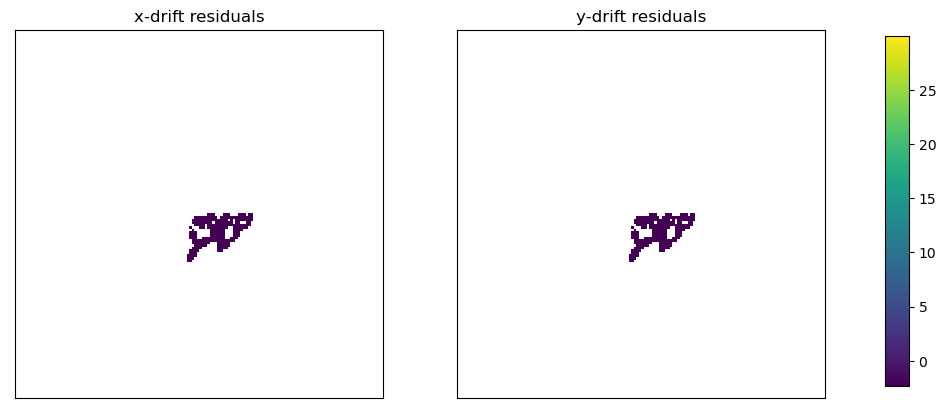

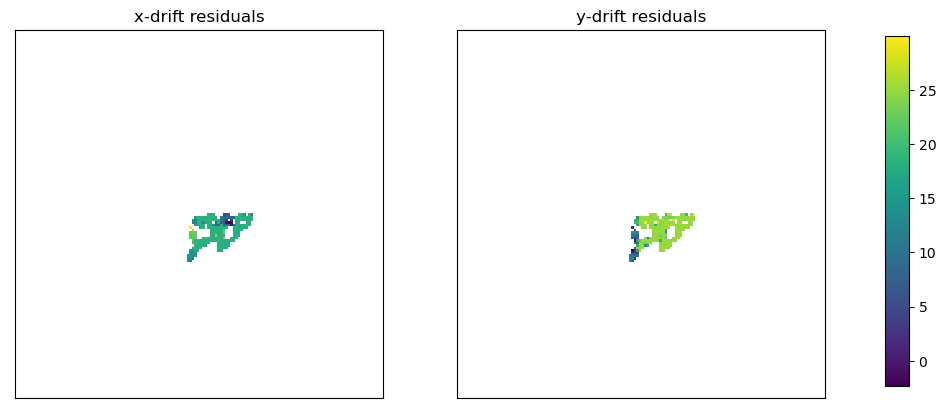

In [64]:
# Plot ice drift residuals

print("pixshx = ", pixshx)
pixsize = 5.0
print("pixshx * pixsize = ", pixshx * pixsize)
testx = np.full_like(driftx, pixshx * pixsize)
testy = np.full_like(drifty, pixshy * pixsize)
testdata = {'dx': testx, 'dy': testy}
resx = driftx - np.full_like(driftx, pixshx * pixsize)
resy = drifty - np.full_like(drifty, pixshy * pixsize)
resdata = {'dx': resx, 'dy': resy}

fig = plt.figure(figsize=(12,7))
ax = {}
c = {}
for i, var in enumerate(list(testdata.keys())):
    ax[i] = fig.add_subplot(1,len(testdata),i+1)
    c[i] = ax[i].imshow(testdata[var][:], interpolation = 'none', origin='lower', cmap=cmap)
    ax[i].invert_yaxis()
    ax[i].set_title('{}-drift residuals'.format(var[1:2]), fontsize=12)
    ax[i].xaxis.set_tick_params(labelbottom=False)
    ax[i].yaxis.set_tick_params(labelleft=False)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(c1, cax=cbar_ax, shrink=0.5)


fig = plt.figure(figsize=(12,7))
ax = {}
c = {}
for i, var in enumerate(list(resdata.keys())):
    ax[i] = fig.add_subplot(1,len(resdata),i+1)
    c[i] = ax[i].imshow(resdata[var][:], interpolation = 'none', origin='lower', cmap=cmap)
    ax[i].invert_yaxis()
    ax[i].set_title('{}-drift residuals'.format(var[1:2]), fontsize=12)
    ax[i].xaxis.set_tick_params(labelbottom=False)
    ax[i].yaxis.set_tick_params(labelleft=False)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(c1, cax=cbar_ax, shrink=0.5)

In [ ]:
# Plot ice drift flags

cmap = cm.jet
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1,1,1)
c1 = ax1.imshow(idrift['flag'][:], interpolation = 'none', origin='lower', cmap=cmap)
ax1.set_title("flag")
fig.colorbar(c1, ax=ax1, location='right', anchor=(0, 0.3), shrink=0.7)

In [ ]:
# Will need to alter icedrift code so that the forward and backward scans are treated the same as the 
# H and V polarisations, and combined within the drift algorithm. Note that the forward and backward scans are 
# actually separated by 7 minutes, so later on we can try to use the time shift between these too.